In [1]:
import os
if os.getcwd().endswith('notebooks'):
    # if we are in the notebooks folder, we move to the root folder 
    os.chdir('..')

# MovieLens Fairness Gym Environment

In [2]:
# we start by importing the environment module
from pydeeprecsys.movielens_fairness_env import MovieLensFairness
import gym
# then we can create a gym environment with a particular slate size
env = gym.make('MovieLensFairness-v0', slate_size=3)
type(env)

gym.wrappers.time_limit.TimeLimit

Now we can understand what are states, actions and rewards in this environment. Let's start with state

In [3]:
env.observation_space

Box(0.0, 1.0, (25,), float32)

So we have 25 variables, in the (0,1) range:
- 4 variables represent scaled (sex, age, occupation, zip code)
- 19 variables, that are one-hot encodings for the category of the latest reviewed movie. Categories include Action, Crime, Thriller, and so on
- 1 variable for the user's 5 star rating.
- 1 variable for the movie's violence score.

Let's see how they look like

In [4]:
env.reset()

array([0.        , 0.01785714, 0.1       , 0.60660607, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

As you can see, the first 4 variables are set. Under the hood, the environment sampled a user from the user pool, and prepared it. The remaining variables are `0` because no movie has been recommended yet. Let's see how recommendations are made:

In [5]:
env.action_space

MultiDiscrete([3883 3883 3883])

Since we set our `slate_size` to `3`, this means that at each step the agent must recommend `3` movies. Recommendations are made based on the (discrete) movie identifier, that's why the action space is of type `MultiDiscrete`. `3883` is the amount of available movies. Let's make a recommendation: 

In [6]:
random_slate = env.action_space.sample()
random_slate

array([3723, 1525, 3048])

In [7]:
state, reward, done, info = env.step(random_slate)

After receiving a recommendation, the user makes a choice, and reviews the movie. Thanks to `Recsim` and `MLFairnessGym` we can:
- affect the behavior of users after being exposed to movies, by encoding addiction/boredom dynamics into the user embedding
- encode the violence score into the reward, so that recommending too many violent movies brings a negative reward 

Let's see the new state:

In [8]:
state

array([0.        , 0.01785714, 0.1       , 0.60660607, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ])

We can also inspect the reward, which is in range (0,1):

In [9]:
reward

1.0

And we can check if the episode is done. Currently, episodes are finished when the simulated user has rated `50` movies.

In [10]:
done

False

# Training a Random Agent

The `Manager` class facilitates a lot of things like training, hyperparameter optimization, and so on.

In [11]:
from pydeeprecsys.rl.manager import MovieLensFairnessManager
from pydeeprecsys.rl.agents.agent import RandomAgent
from pydeeprecsys.rl.learning_statistics import LearningStatistics

In [12]:
manager = MovieLensFairnessManager(slate_size=1)
manager.print_overview()

Reward threshold: inf 
Reward signal range: (-inf, inf) 
Maximum episode steps: 50 
Action apace size: Discrete(3883)
Observation space size Box(0.0, 1.0, (25,), float32) 


In [13]:
agent = RandomAgent(action_space=manager.env.action_space)
stats = LearningStatistics()
manager.train(agent, stats, max_episodes=200, should_print=True)

Training...
Episode 199 Mean Rewards 31.38 Last Reward 18.44		

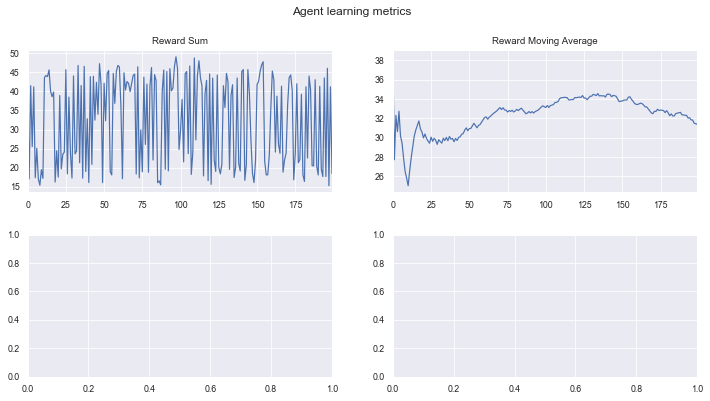

In [14]:
stats.plot_learning_stats()